# 평가 조건
- 평가 문항
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?
 - 학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
 - 오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
 - 60% 이상 도달하였음

# 모듈 임포트

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

# 데이터 만들기
- https://teachablemachine.withgoogle.com/ 여기에서 무료로 사진 만들수 있음
- 디렉토리 만들기
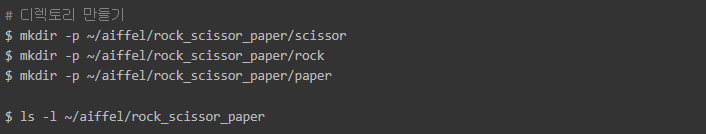
- 사진 압축 해제
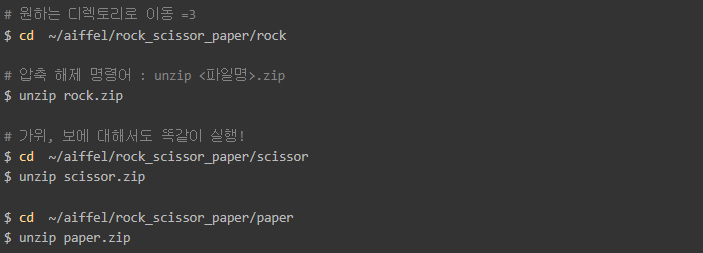

## 사진 28,28로 resize

In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

	target_size=(28,28) #파일마다 모두 28x28 사이즈로 바꾸어 저장
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [3]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/lsh"
resize_images(image_dir_path)

print("가위 이미지 resize 완료")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료


In [4]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/lsh"
resize_images(image_dir_path)

print("바위 이미지 resize 완료")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료


In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/lsh"
resize_images(image_dir_path)

print("보 이미지 resize 완료")

100  images to be resized.
100  images resized.
보 이미지 resize 완료


## load_data 함수 만들기

In [6]:
import numpy as np

def load_data(img_path, number_of_data=300):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [7]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


## 데이터 확인

라벨:  0


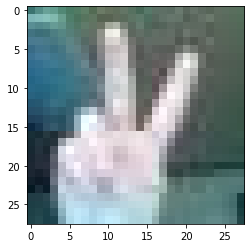

In [8]:
plt.imshow(x_train[1])
print('라벨: ', y_train[1])

# 모델 만들기

In [9]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [10]:
#딥러닝 모델 확인

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

# 학습시키기

In [11]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 3s 12ms/step - loss: 22.4532 - accuracy: 0.3033
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 3.0118 - accuracy: 0.5500
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7277 - accuracy: 0.8333
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4449 - accuracy: 0.9033
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.1578 - accuracy: 0.9500
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 0.9967
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 2.2999e-04 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 1.2905e-04 - accuracy: 1.0000


## 평가데이터 셋 만들기
- testset은 같이 교육을 듣는 다른 그루분의 사진으로 test 진행
- trainset과 똑같이 알집 파일을 풀어줘야함
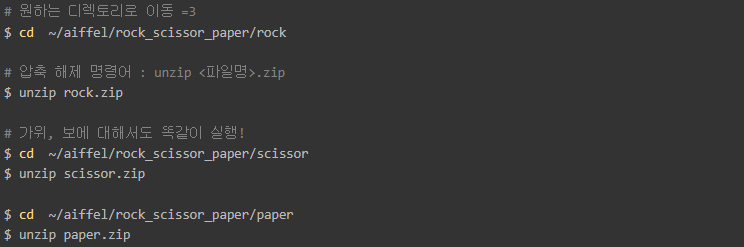

In [12]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

print("테스트 가위 이미지 resize 완료")

100  images to be resized.
100  images resized.
테스트 가위 이미지 resize 완료


In [13]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("테스트 바위 이미지 resize 완료")

100  images to be resized.
100  images resized.
테스트 바위 이미지 resize 완료


In [14]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("테스트 보 이미지 resize 완료")

100  images to be resized.
100  images resized.
테스트 보 이미지 resize 완료


In [15]:
import numpy as np

def test_load_data(img_path, number_of_data=300):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


In [16]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=test_load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


# 모델 평가

In [17]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 8.3007 - accuracy: 0.3267
test_loss: 8.300652503967285
test_accuracy: 0.3266666531562805


- 1차적인 베이스라인는 정확도가 약 0.32정도 나왔음

## 모델 추론값 확인

In [18]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [9.9936646e-01 3.4025984e-09 6.3359656e-04]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


예측확률분포: [3.8204327e-01 2.5285922e-09 6.1795670e-01]
라벨: 1, 예측결과: 2


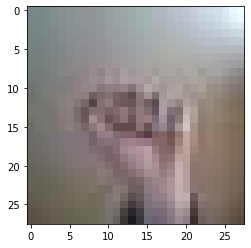

예측확률분포: [2.1232261e-01 4.1344745e-09 7.8767735e-01]
라벨: 1, 예측결과: 2


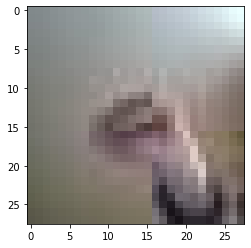

예측확률분포: [8.5710269e-01 9.1478549e-09 1.4289732e-01]
라벨: 1, 예측결과: 0


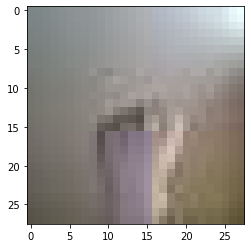

예측확률분포: [9.4636965e-01 3.2436744e-11 5.3630367e-02]
라벨: 2, 예측결과: 0


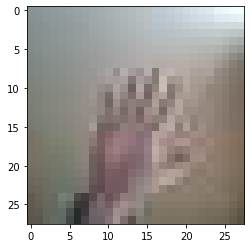

예측확률분포: [2.4830982e-01 1.3608478e-10 7.5169015e-01]
라벨: 0, 예측결과: 2


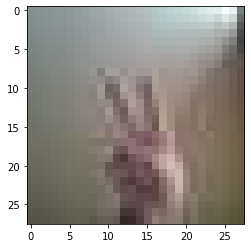

In [19]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()
    
#0: 가위 / 1: 바위 / 2: 보

- 예측 결과를 확인해본 결과, 사진이 흐릿해서 제대로 예측을 못하는 것인지 파악이 안됨
- 또한 300개 데이터를 학습하였는데, 학습 당시의 accuracy를 보면 오버피팅이 되었음
- 학습 데이터의 수를 사진의 위치를 90도 회전 시키거나, 180도 뒤집는 방법등으로 늘려주는 것도 괜찮을 것이라고 생각되며, 추가적으로 그루분들의 사진도 추가하는것도 방법이 될 수 있음
- 그리고 모델 layer를 더 설계하는 방법도 존재하고, parameter값도 변경해줄 수 있음

## 성능을 향상시킬 수 있는 방법 정리
1. 학습 데이터의 수를 늘린다.
 - 사진을 회전 및 뒤집기, 그루분들의 사진 추가 등
2. 모델 layer를 추가로 구성한다.
3. dropout 등의 방법 사용
4. hyper parameter값들을 수정한다.
5. 여러가지 방법 조합 시도

## 1. 학습 데이터의 수를 늘린다.
 - 사진을 회전 및 뒤집기, 그루 사진 추가
 - https://hipolarbear.tistory.com/19 참고

In [20]:
import re

def Augmentation_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    new_path = img_path
    print(len(images), " images to be resized.")
    
    target_size=(28,28) #파일마다 모두 28x28 사이즈로 바꾸어 저장
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    for img in images: #이미지 좌우 반전
        old_img=Image.open(img)
        LEFT_RIGHT_new_img = old_img.transpose(Image.FLIP_LEFT_RIGHT)
        numbers = re.sub(r'[^0-9]', '', img)
        LEFT_RIGHT_new_img.save(new_path+'/'+numbers+'_LEFT_RIGHT.jpg',"JPEG")
    
    print('이미지 좌우 반전 완료')
    
    for img in images: #이미지 상하 반전
        old_img=Image.open(img)
        TOP_BOTTOM_new_img = old_img.transpose(Image.FLIP_TOP_BOTTOM)
        numbers = re.sub(r'[^0-9]', '', img)
        TOP_BOTTOM_new_img.save(new_path+'/'+numbers+'_TOP_BOTTOM.jpg',"JPEG")

    print('이미지 상하 반전 완료')
    
    new_images=glob.glob(img_path + "/*.jpg")
    print(len(new_images), " images Augmentation.")

In [21]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/lsh"
Augmentation_images(image_dir_path)

print("가위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
가위 이미지 Augmentation 완료


In [22]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/lsh"
Augmentation_images(image_dir_path)

print("바위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
바위 이미지 Augmentation 완료


In [23]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/lsh"
Augmentation_images(image_dir_path)

print("보 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
보 이미지 Augmentation 완료


In [24]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/llsh"
Augmentation_images(image_dir_path)

print("가위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
가위 이미지 Augmentation 완료


In [25]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/llsh"
Augmentation_images(image_dir_path)

print("바위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
바위 이미지 Augmentation 완료


In [26]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/llsh"
Augmentation_images(image_dir_path)

print("보 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
보 이미지 Augmentation 완료


In [27]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/psw"
Augmentation_images(image_dir_path)

print("가위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
가위 이미지 Augmentation 완료


In [28]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/psw"
Augmentation_images(image_dir_path)

print("바위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
바위 이미지 Augmentation 완료


In [29]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/psw"
Augmentation_images(image_dir_path)

print("보 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
보 이미지 Augmentation 완료


### load_data 함수 만들기

In [30]:
import numpy as np

def ag_load_data(img_path, number_of_data=900):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [31]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train1, y_train1)=ag_load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train1.shape))
print("y_train shape: {}".format(y_train1.shape))

학습데이터(x_train)의 이미지 개수는 900 입니다.
x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


In [34]:
import numpy as np

def ag_load_data(img_path, number_of_data=900):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/llsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/llsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/llsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [35]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train2, y_train2)=ag_load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train2.shape))
print("y_train shape: {}".format(y_train2.shape))

학습데이터(x_train)의 이미지 개수는 900 입니다.
x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


In [37]:
import numpy as np

def ag_load_data(img_path, number_of_data=900):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/psw/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/psw/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/psw/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [38]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train3, y_train3)=ag_load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train3.shape))
print("y_train shape: {}".format(y_train3.shape))

학습데이터(x_train)의 이미지 개수는 900 입니다.
x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


### 데이터 합치기

In [40]:
ag_x_train = np.concatenate([x_train1, x_train2, x_train3], 0)
ag_y_train = np.concatenate([y_train1, y_train2, y_train3], 0)

In [41]:
print("ag_x_train shape: {}".format(ag_x_train.shape))
print("ag_y_train shape: {}".format(ag_y_train.shape))

ag_x_train shape: (2700, 28, 28, 3)
ag_y_train shape: (2700,)


### 모델 학습

In [44]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [45]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(ag_x_train, ag_y_train, epochs=10)

Epoch 1/10
85/85 [==============================] - 1s 3ms/step - loss: 4.6311 - accuracy: 0.4856
Epoch 2/10
85/85 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.7415
Epoch 3/10
85/85 [==============================] - 0s 3ms/step - loss: 0.3193 - accuracy: 0.8796
Epoch 4/10
85/85 [==============================] - 0s 3ms/step - loss: 0.2004 - accuracy: 0.9285
Epoch 5/10
85/85 [==============================] - 0s 3ms/step - loss: 0.1105 - accuracy: 0.9633
Epoch 6/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0676 - accuracy: 0.9778
Epoch 7/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0351 - accuracy: 0.9893
Epoch 8/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9907
Epoch 9/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9904
Epoch 10/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0134 - accuracy: 0.9978


### 모델 평가

In [46]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.8487 - accuracy: 0.6200
test_loss: 0.8486971259117126
test_accuracy: 0.6200000047683716


## 2. 모델 layer를 추가로 구성한다.

In [56]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  9


In [57]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(ag_x_train, ag_y_train, epochs=10)

Epoch 1/10
85/85 [==============================] - 1s 4ms/step - loss: 1.7308 - accuracy: 0.5152
Epoch 2/10
85/85 [==============================] - 0s 4ms/step - loss: 0.5485 - accuracy: 0.7656
Epoch 3/10
85/85 [==============================] - 0s 4ms/step - loss: 0.2889 - accuracy: 0.8952
Epoch 4/10
85/85 [==============================] - 0s 4ms/step - loss: 0.1686 - accuracy: 0.9437
Epoch 5/10
85/85 [==============================] - 0s 4ms/step - loss: 0.1255 - accuracy: 0.9622
Epoch 6/10
85/85 [==============================] - 0s 4ms/step - loss: 0.0742 - accuracy: 0.9819
Epoch 7/10
85/85 [==============================] - 0s 4ms/step - loss: 0.0703 - accuracy: 0.9815
Epoch 8/10
85/85 [==============================] - 0s 4ms/step - loss: 0.0417 - accuracy: 0.9889
Epoch 9/10
85/85 [==============================] - 0s 4ms/step - loss: 0.0562 - accuracy: 0.9826
Epoch 10/10
85/85 [==============================] - 0s 4ms/step - loss: 0.0199 - accuracy: 0.9967


In [58]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.7917 - accuracy: 0.6333
test_loss: 0.7917166352272034
test_accuracy: 0.6333333253860474


## 3. dropout 등의 방법 사용

In [59]:
from keras.layers import Dropout

np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(Dropout(0.15))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.15))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  9


In [60]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(ag_x_train, ag_y_train, epochs=10)

Epoch 1/10
85/85 [==============================] - 1s 3ms/step - loss: 7.6624 - accuracy: 0.3389
Epoch 2/10
85/85 [==============================] - 0s 3ms/step - loss: 1.1103 - accuracy: 0.3296
Epoch 3/10
85/85 [==============================] - 0s 3ms/step - loss: 1.1065 - accuracy: 0.3348
Epoch 4/10
85/85 [==============================] - 0s 3ms/step - loss: 1.1063 - accuracy: 0.3352
Epoch 5/10
85/85 [==============================] - 0s 3ms/step - loss: 1.1001 - accuracy: 0.3374
Epoch 6/10
85/85 [==============================] - 0s 3ms/step - loss: 1.0982 - accuracy: 0.3307
Epoch 7/10
85/85 [==============================] - 0s 3ms/step - loss: 1.0922 - accuracy: 0.3422
Epoch 8/10
85/85 [==============================] - 0s 3ms/step - loss: 1.0941 - accuracy: 0.3441
Epoch 9/10
85/85 [==============================] - 0s 3ms/step - loss: 1.0502 - accuracy: 0.4041
Epoch 10/10
85/85 [==============================] - 0s 3ms/step - loss: 1.0272 - accuracy: 0.4163


In [61]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 1.1003 - accuracy: 0.3333
test_loss: 1.1002861261367798
test_accuracy: 0.3333333432674408


## 4. hyper parameter값들을 수정한다.

In [62]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [63]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(ag_x_train, ag_y_train, epochs=10)

Epoch 1/10
85/85 [==============================] - 1s 4ms/step - loss: 4.2582 - accuracy: 0.6181
Epoch 2/10
85/85 [==============================] - 0s 3ms/step - loss: 0.2245 - accuracy: 0.9256
Epoch 3/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9833
Epoch 4/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9967
Epoch 5/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 0.9993
Epoch 6/10
85/85 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 7/10
85/85 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 8/10
85/85 [==============================] - 0s 3ms/step - loss: 8.7768e-04 - accuracy: 1.0000
Epoch 9/10
85/85 [==============================] - 0s 3ms/step - loss: 5.8295e-04 - accuracy: 1.0000
Epoch 10/10
85/85 [==============================] - 0s 3ms/step - loss: 4.4156e-04 - accuracy: 1.0000


In [64]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 2.6359 - accuracy: 0.4100
test_loss: 2.63588809967041
test_accuracy: 0.4099999964237213


- 학습데이터 추가와 모델의 layer를 추가하여 루브릭 조건인 accuracy 60%를 넘을 수 있었음
- 추가적으로 위에서 사용한 방법들을 조합하여 시도해보았음

## 5. 여러가지 방법 조합 시도

In [75]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(1,1))
model.add(Dropout(0.30))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((1,1)))
model.add(Dropout(0.30))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.30))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(Dropout(0.30))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  13


In [76]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(ag_x_train, ag_y_train, epochs=10)

Epoch 1/10
85/85 [==============================] - 1s 7ms/step - loss: 23.9955 - accuracy: 0.3356
Epoch 2/10
85/85 [==============================] - 1s 6ms/step - loss: 1.0971 - accuracy: 0.3700
Epoch 3/10
85/85 [==============================] - 1s 6ms/step - loss: 1.0069 - accuracy: 0.4648
Epoch 4/10
85/85 [==============================] - 1s 6ms/step - loss: 0.7994 - accuracy: 0.6067
Epoch 5/10
85/85 [==============================] - 1s 6ms/step - loss: 0.6457 - accuracy: 0.6952
Epoch 6/10
85/85 [==============================] - 1s 6ms/step - loss: 0.5072 - accuracy: 0.7852
Epoch 7/10
85/85 [==============================] - 1s 6ms/step - loss: 0.3438 - accuracy: 0.8500
Epoch 8/10
85/85 [==============================] - 1s 6ms/step - loss: 0.2789 - accuracy: 0.8959
Epoch 9/10
85/85 [==============================] - 1s 6ms/step - loss: 0.2121 - accuracy: 0.9207
Epoch 10/10
85/85 [==============================] - 1s 6ms/step - loss: 0.1278 - accuracy: 0.9563


In [77]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.6318 - accuracy: 0.7300
test_loss: 0.6317572593688965
test_accuracy: 0.7300000190734863


# 전체 회고
- 케라스 모델을 이용하여 이미지 분류 모델을 만들어보았음
- 학습데이터와 layer를 추가하여 루브릭 조건을 달성할 수 있었지만, 추가적인 방법들을 적용하여 73%의 정확도를 달성하였음
- 이번 exploration은 데이터를 내가 직접 만들었다는 것이 재미가 있었음
- 이미지를 많이 다뤄보지 않았지만, 이미지도 다루다 보니 재미가 있다는 생각이 들었음
- 성능을 올리기 위하여 다양한 방법들을 생각하고 시도하느라 모델과 함수를 수정하는것이 재미있었음
- 데이터를 증강시키는 코드를 효율적으로 만들지 못해서 조금은 아쉬움
- 딥러닝은 학습 데이터가 많은 것이 과적합을 방지할 수 있는 첫번째인것 같고, 추가적으로 dropout 등의 기술도 중요하다고 생각됨
- 이번 exploration을 하면서 이미지 딥러닝에 대해 스스로 찾아보고 공부할 수 있었으며, 모델을 설계하는 방법이나 과적합을 방지하는 방법 등을 아직 완벽하게 이해한것은 아니지만, 공부할 수 있어서 좋았음